In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [4]:
main_path = os.getcwd() + '/covid_data'

train_dataset = train_datagen.flow_from_directory(
    directory= main_path + '/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=None)

val_dataset = val_datagen.flow_from_directory(
    directory = main_path + '/validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=150,
    class_mode="categorical",
    shuffle=False,
    seed=None)

test_dataset = test_datagen.flow_from_directory(
    directory = main_path + '/test',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=150,
    class_mode="categorical",
    shuffle=False,
    seed=None)

Found 14811 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [5]:
for image_batch, labels_batch in train_dataset:
  print('Image Shape: {}'.format(image_batch.shape))
  print('Label Shape: {}'.format(labels_batch.shape))
  break

Image Shape: (32, 224, 224, 3)
Label Shape: (32, 4)


In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# Load pre-trained ResNet50 model with pre-trained weights and without top layers
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

58900480/58889256 [==============================] - 2s 0us/step


In [7]:
history = model.fit(train_dataset, validation_data=val_dataset,  epochs=50)

Epoch 1/50
463/463 [==============================] - 104s 216ms/step - loss: 0.9691 - accuracy: 0.5931 - val_loss: 0.8423 - val_accuracy: 0.6767
Epoch 2/50
463/463 [==============================] - 97s 208ms/step - loss: 0.7876 - accuracy: 0.6910 - val_loss: 0.7409 - val_accuracy: 0.7178
Epoch 3/50
463/463 [==============================] - 91s 197ms/step - loss: 0.7106 - accuracy: 0.7374 - val_loss: 0.6748 - val_accuracy: 0.7574
Epoch 4/50
463/463 [==============================] - 86s 185ms/step - loss: 0.6616 - accuracy: 0.7605 - val_loss: 0.6337 - val_accuracy: 0.7787
Epoch 5/50
463/463 [==============================] - 88s 191ms/step - loss: 0.6250 - accuracy: 0.7794 - val_loss: 0.6241 - val_accuracy: 0.7758
Epoch 6/50
463/463 [==============================] - 89s 193ms/step - loss: 0.5995 - accuracy: 0.7880 - val_loss: 0.5810 - val_accuracy: 0.7820
Epoch 7/50
463/463 [==============================] - 86s 185ms/step - loss: 0.5750 - accuracy: 0.7992 - val_loss: 0.5552 - val_a

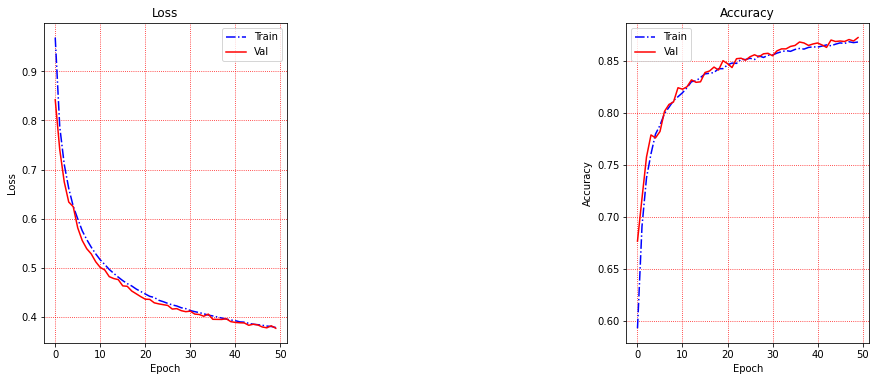

In [9]:
plt.figure(figsize = (20, 20))
plt.subplot(341)
plt.plot(history.history['loss'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_loss'], color='red', linestyle="solid", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

plt.subplot(343)
plt.plot(history.history['accuracy'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_accuracy'], color='red', linestyle="solid", label='Val')
# plt.xticks(np.arange(0, 31, step=2))  # Set label locations.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

In [10]:
test_result = model.evaluate(test_dataset, batch_size = 128)

29/29 [==============================] - 25s 868ms/step - loss: 0.3900 - accuracy: 0.8638


In [11]:
print('Test Loss: {}'.format(test_result[0]))
print('Test Accuracy: {}'.format(test_result[1]))

Test Loss: 0.39004817605018616
Test Accuracy: 0.8637544512748718


In [13]:
class_names = list(train_dataset.class_indices)

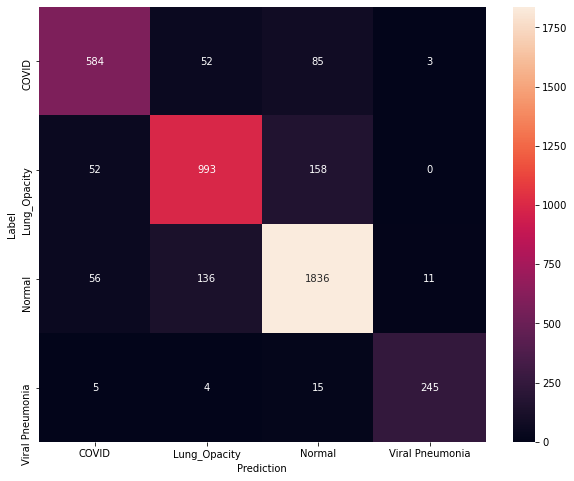

In [14]:
label_names = class_names
y_pred = model.predict(test_dataset, batch_size=128)
y_test = test_dataset.labels
cm = tf.math.confusion_matrix(y_test, 
                              y_pred.argmax(axis=1),
                              num_classes = 4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
              annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('CM.png', dpi = 300)
plt.show()